In [2]:
import os
import pandas as pd

import numpy as np
from numpy import exp
from numpy import log
from numpy import sqrt
from numpy import power
import matplotlib.pyplot as plt

import scipy
from scipy import special

import math
from math import pi
from math import erf
from math import erfc
os.getcwd()


'/workspaces/Reproduce-of-OOK-CNNs-Demudulation'

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir("/content/drive/MyDrive/Colab Notebooks/UOWC")
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/Colab Notebooks/UOWC'

In [9]:

def Simulated_dataset(SNR,Z,P):
  """

  Args:
    SNR: signl to noise ratios
    Z: channel lenth
    P: transmission power

  Returns:S_1,S_0,Denm_trm1,Denm_trm0,Threshold_optimal
   the function returns: numrical signal of bit 1 bit 0 , standard divation of bit 1 noise ,bit 0 noise,optimal Threshold

  """
  ######## Receiver SiPM ::MICROFC−SMTPA−30035
  PDE = 0.31 #photo detection efficiency 3mm Sensor 35um - 30035, overvoltage @ 2.5V
  lamda=420e-9 #Wavelength of Blue light
  A=0.0058  #SiPM surface area
  G=3e6 #Gain
  pap=0.002 #probability of afterpulsing
  pct=0.07 #probability of crosstalk
  dCR=300 #dark count rate6.6*10^6
  c=2.25e8 #light speed
  hp=6.626e-34  # Planck's constant h,
  e=1.6e-19  # Charge of Electron
  Nspad=4774 #  number of SPAD (microcells)
  td= 82e-9  #  tau_d deadtimex

  P_AP=1+pap #  probability of current
  P_XT = 1 + pct
  
  Res=PDE*lamda*G*e*P_AP*P_XT/(hp*c)  # what? SiPM responsitivity
  Fe=1.1  # funtion of the doping profile

  #  Laser Diode Parameters
  ext=0.33 # extinction ratio
  Ptx1 =(1-ext)*P  #[0.25,0.40,0.5] #  power of bit 1 in watt
  Ptx0=ext*P    # 0.0008   wpower of bit 0 in watt
  
  ce = 0.551 ##channel loss diffuse coefficient
  Rb = 10e6#[10,30,60]e6 #transmitt data rate
  RL = 1000 #load resistance
  Lch=math.exp(-ce*Z) # channel loss
  h_L=Lch # channel loss factor
  lenth=int(1e4)#  length of the signal and noise

#####total channel gain
  h_gain = h_L #*h_P#*h_T without turbulence without pointing error
#######    noise  ######
  sgma2_0_tn = Ptx0/power(10,SNR/10) #variance of the total signal noise for bit 1
  sgma2_1_tn = Ptx1/power(10,SNR/10) #variance of the total signal noise for bit 0
  #the noise  of bit 1 is normaly distributed
  Noise_0 = np.random.normal(0, np.sqrt(sgma2_0_tn), lenth)
  Noise_1 = np.random.normal(0, np.sqrt(sgma2_1_tn), lenth)
####The optical signal received by the SiPM after underwater propagation
  S_R0 = Res*h_gain*Ptx0 + Noise_0
  S_R1 = Res*h_gain*Ptx1 + Noise_1 
####the input signals to the demodulator corresponding to “0” and “1” bits,
  S_0 = RL*S_R0*1e-8 # nurmical simulated current of bit 1
  S_1 = RL*S_R1*1e-8# nurmical simulated current of bit 0
#
  Denm_trm1 = sqrt(sgma2_1_tn) # standard deviation of bit 1
  Denm_trm0 = sqrt(sgma2_0_tn) # standard deviation of bit 0

#### Here calculate the optimal threshold
  Threshold_optimal = (S_0*sgma2_1_tn - S_1*sgma2_0_tn)/(sgma2_1_tn-sgma2_0_tn) + np.sqrt((power(S_1,2)*sgma2_0_tn)/(sgma2_1_tn-sgma2_0_tn) + power((S_0*sgma2_1_tn
    - S_1*sgma2_0_tn)/(sgma2_1_tn-sgma2_0_tn),2) - (power(S_0,2)*sgma2_1_tn)/(sgma2_1_tn - sgma2_0_tn)
     - ((sgma2_0_tn*sgma2_1_tn)/(sgma2_1_tn - sgma2_0_tn))*log(sgma2_0_tn/sgma2_1_tn) )

  return S_1,S_0,Denm_trm1,Denm_trm0,Threshold_optimal


[1.1062508250979275e-45]
[1.1062508250979275e-45, 1.8368363902272117e-16]
[1.1062508250979275e-45, 1.8368363902272117e-16, 1.320773585687939e-06]
[1.1062508250979275e-45, 1.8368363902272117e-16, 1.320773585687939e-06, 0.0033907117221852546]
[1.1062508250979275e-45, 1.8368363902272117e-16, 1.320773585687939e-06, 0.0033907117221852546, 0.05924784996437558]
[1.1062508250979275e-45, 1.8368363902272117e-16, 1.320773585687939e-06, 0.0033907117221852546, 0.05924784996437558, 0.18353867500698817]
[1.1062508250979275e-45, 1.8368363902272117e-16, 1.320773585687939e-06, 0.0033907117221852546, 0.05924784996437558, 0.18353867500698817, 0.29919087447321124]
[1.1062508250979275e-45, 1.8368363902272117e-16, 1.320773585687939e-06, 0.0033907117221852546, 0.05924784996437558, 0.18353867500698817, 0.29919087447321124, 0.3745628414637915]


<function matplotlib.pyplot.show(close=None, block=None)>

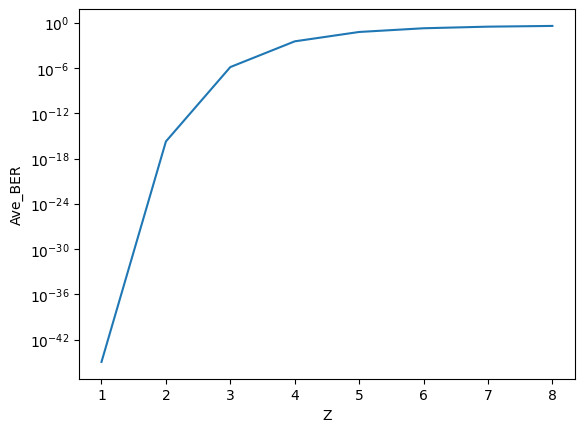

In [20]:
#####test 
# Here the equations are tested to see if they are working properly and if the correct BER can be obtained
SNR = 30
Avg_BER1=[]
Zb = np.linspace(1,8,8)
for Z in Zb:
    P = 0.25    #[0.25,0.40,0.5]
    N_s1,N_s0,D_s1,D_s0,Threshold = Simulated_dataset(SNR,Z,P)
    
    Avg_BER_Inst =  0.25*special.erfc(((Threshold - N_s0)/D_s0)) +0.25*special.erfc(((N_s1 - Threshold)/D_s1))
    Avg_BER1.append(np.mean(Avg_BER_Inst))
    print(Avg_BER1)
plt.semilogy(Zb,Avg_BER1)
plt.xlabel("Z")
plt.ylabel("Ave_BER")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

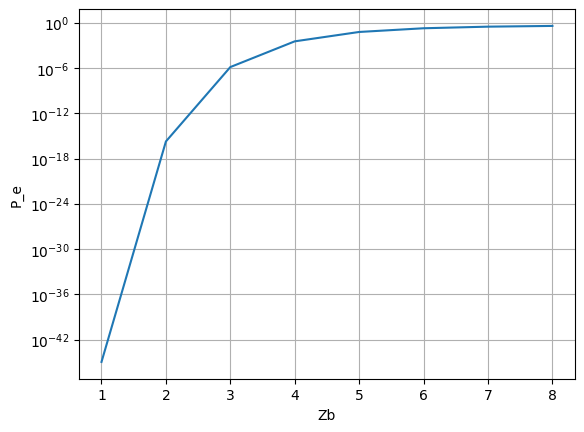

In [21]:
######Application of the function

Zb = np.linspace(1,8,8) # link range
SNR = 30
P = 0.25
Avg_BER1=[]
for Z in Zb:
  N_s1,N_s0,D_s1,D_s0,Threshold = Simulated_dataset(SNR,Z,P)
  Avg_BER_Inst =  0.25*special.erfc(((Threshold - N_s0)/D_s0)) +0.25*special.erfc(((N_s1 - Threshold)/D_s1))
  Avg_BER1.append(np.mean(Avg_BER_Inst))

plt.semilogy(Zb,Avg_BER1)  # 对 result 取 log 后画线
plt.xlabel("Zb")
plt.ylabel("P_e")
plt.grid(True)
plt.show
